In [25]:
# https://www.youtube.com/watch?v=ok2s1vV9XW0
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from gensim.models import FastText

In [74]:
def apply_mask(inputs, mask_list, columns):
    for column in columns: 
        for mask in mask_list: 
            inputs[column] = np.where(inputs[column].between(mask[0], mask[1]), mask[2], inputs[column])
    return inputs

def make_lex_data(dataset_name, features, wc_mask, rel_mask, normalize):
    affect_mapping = {"happiness": 0, "sadness": 1, "anger": 2, "fear": 3, "disgust": 4}
    dataset = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv")
    dataset["a"] = [affect_mapping[affect] for affect in dataset["a"].tolist()]
    
    if normalize: 
            l = min(len(dataset.loc[dataset["a"] == 0]), len(dataset.loc[dataset["a"] == 1]), len(dataset.loc[dataset["a"] == 2]), len(dataset.loc[dataset["a"] == 3]))
            dataset = pd.concat([dataset.loc[dataset["a"] == 0][:l], dataset.loc[dataset["a"] == 1][:l], dataset.loc[dataset["a"] == 2][:l], dataset.loc[dataset["a"] == 3][:l]], axis=0, ignore_index=True)

    targets = dataset["a"]
    inputs = dataset.drop(["t", "a"], axis="columns")
    tmp = dataset.drop(["t", "a", "wc"], axis="columns")
    
    inputs = apply_mask(inputs, wc_mask, tmp.columns)
    inputs = apply_mask(inputs, wc_mask, ["wc"])
    inputs = inputs.astype(int)
    train_x, test_x, train_y, test_y = train_test_split(inputs, targets, test_size=0.2)
    return train_x, test_x, train_y, test_y    

def make_vector_data(dataset_name):
    affect_mapping = {"happiness": 0, "sadness": 1, "anger": 2, "fear": 3, "disgust": 4}
    sentences = pd.read_csv("../cleaned/" + dataset_name + "_stems.csv", delimiter=",").astype(str).values.tolist()
    targets = pd.read_csv("../cleaned/" + dataset_name + "_clean.csv", delimiter=",").astype(str)["a"].tolist() 
    
    if normalize: 
        l = min(len(dataset.loc[dataset["a"] == 0]), len(dataset.loc[dataset["a"] == 1]), len(dataset.loc[dataset["a"] == 2]), len(dataset.loc[dataset["a"] == 3]))
        dataset = pd.concat([dataset.loc[dataset["a"] == 0][:l], dataset.loc[dataset["a"] == 1][:l], dataset.loc[dataset["a"] == 2][:l], dataset.loc[dataset["a"] == 3][:l]], axis=0, ignore_index=True)
    
    
    
    # remove placeholder, map affect to number
    for index, sample in enumerate(sentences): 
            sentences[index] = list(filter(("__").__ne__, sample))
    targets = [affect_mapping[affect] for affect in targets]
    # make one-string-sentences
    inputs = [" ".join(sentence) for sentence in sentences]
    
    # build model over sentences (size=dimension of word vectors)
    model = FastText(size=16, window=3, min_count=1)
    model.build_vocab(inputs)  
    model.train(sentences=inputs, total_examples=len(inputs), total_words=model.corpus_total_words, epochs=5)
    # convert sentences to vectors
    inputs = [model.wv[sample] for sample in inputs]
    
    # split data and return
    train_x, test_x, train_y, test_y = train_test_split(inputs, targets, test_size=0.2)
    return train_x, test_x, train_y, test_y    

def create_model(train_x, test_x, train_y, test_y): 
    rf = RandomForestClassifier(n_estimators=50)
    rf.fit(train_x, train_y)
    pred_y = rf.predict(test_x)
    # model metadata
    print("trees: 50\tscore: ", rf.score(train_x, train_y))
    print("...feature importance\n", rf.feature_importances_)
    print("weighted f1_score: ", f1_score(test_y, pred_y, average="weighted"))
    # draw confusion matric
    cm = confusion_matrix(test_y, pred_y)
    sn.heatmap(cm, fmt="d", linewidth=0.5, annot=True, square=True, xticklabels=["h", "s", "a", "f"], yticklabels=["h", "s", "a", "f"])
    plt.xlabel("predicted")
    plt.ylabel("target")
    plt.show()

In [12]:
features = [
    ["wc", "uwc", "ewc", "cpc", "hc", "sc", "ac", "fc"],
    ["wc", "uwc", "ewc", "cpc"],
    ["hc", "sc", "ac", "fc"]
]
wc_mask = [[0,4,0],[5,9,1],[10,14,2],[15,24,3],[25,34,4],[35,49,5],[50,99,6]]
rel_mask = [[0,0.14,0],[0.15,0.29,1],[0.3,0.44,2],[0.45,0.59,3],[0.6,0.74,4],[0.75,0.89,5],[0.9,1,6]]

trees: 50	score:  0.3066017774016081
...feature importance
 [0.64689939 0.         0.         0.11279409 0.15980601 0.
 0.04188086 0.03861965]
weighted f1_score:  0.27073282189118997


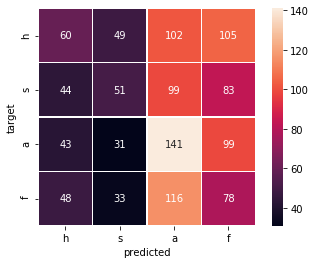

trees: 50	score:  0.29983072365636904
...feature importance
 [0.64176121 0.         0.         0.14572406 0.12495368 0.
 0.04435404 0.04320701]
weighted f1_score:  0.3021488625776829


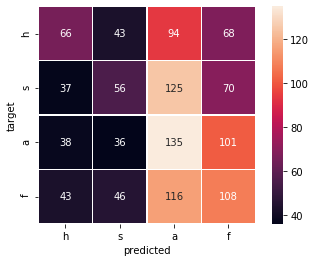

trees: 50	score:  0.30173508252221753
...feature importance
 [0.62791469 0.         0.         0.15102164 0.12571791 0.
 0.04269355 0.05265221]
weighted f1_score:  0.2928644672236742


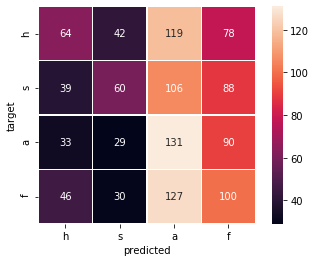

trees: 50	score:  0.9966608594657376
...feature importance
 [0.06251909 0.0629226  0.06172935 0.06286617 0.06317332 0.06201014
 0.06229396 0.06193808 0.06327523 0.06252316 0.06142713 0.0626606
 0.06167183 0.06287512 0.0622056  0.06390861]
weighted f1_score:  0.38443023654243297


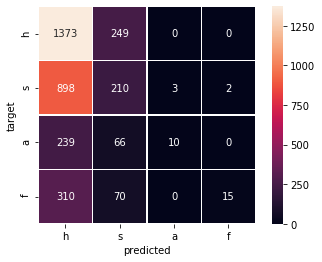

In [75]:
# all models for the emotion dataset
for feature_set in range(len(features)):
    train_x, test_x, train_y, test_y = make_lex_data("tweet", feature_set, wc_mask, rel_mask, True)
    create_model(train_x, test_x, train_y, test_y)
train_x, test_x, train_y, test_y = make_vector_data("tweet")
create_model(train_x, test_x, train_y, test_y)

#@todo bei dem vector_make_data auch normalize einbauen
# dann nei funltion über alle netze drüber laufen lassen
# den kram mit dem vectot-datensatz auch bei der logisctischen regression einbauen
# grafuiken ion die arbeit und beschreiben